In [1]:
#List of all librairies to import
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random


from wordcloud import WordCloud

import plotly.graph_objects as go

import heapq

from collections import deque
from matplotlib.colors import to_hex

import seaborn as sns 

import gzip
import re

Only the code that gives to the actual results is included. Other additional code for testing is not included.

# Betweeness

Here we put the list of used functions

## "Naive" algorithm

As said in the report, we first start designing an algorithm from scratch to compute the betweenness

In [2]:
def naive_algorithm_edge_betweenness(graph,k_sources=None):
    # We create a dictionary to store the betweenness of each edge
    edge_betweenness = {edge: 0 for edge in graph.edges()}

    # We create a list of all the nodes in the graph
    nodes = list(graph.nodes())

    # We choose k_sources random nodes from the list of nodes as sources
    if k_sources is not None and k_sources < len(nodes):
        random.seed(10) 
        sources = random.sample(nodes, k_sources)  # Use k_sources random nodes as sources
    else:
        sources = nodes  #Use all nodes as sources

    ## For each source node
    for s in sources:
        node_time  = {node: float('inf') for node in graph.nodes()} # We create a dictionary to store the "time" at which each node is visited
        node_time[s] = 0 #The source node is visited at time 0

        # We create a dictionary to store the previous edges and the number of shortest paths leading to each node (used to compute the betweenness)
        previous_edges = {node: [[],0] for node in graph.nodes()}

        # We create a queue to store the nodes to be visited
        Q = deque([s])

        # We perform a breadth-first search to find the shortest paths from the source node to all other nodes
        while Q:
            # We visit the first node in the queue
            visited_node = Q.popleft()

            # We visit all the neighbors of the visited node
            for neighbor in graph.neighbors(visited_node):
                # If the neighbor has not been visited yet
                if node_time[neighbor] == float('inf'):
                    node_time[neighbor] = node_time[visited_node] + 1  # Update the time at which the neighbor is visited
                    edge = (visited_node, neighbor) if (visited_node, neighbor) in edge_betweenness else (neighbor, visited_node) #Important: we register the edge in the same way as it is stored in the edge_betweenness dictionary
                    previous_edges[neighbor][0] = previous_edges[visited_node][0] + [edge] #Update the list of previous edges
                    previous_edges[neighbor][1] = 1 #For now, only one shortest path leads to the neighbor
                    Q.append(neighbor) #Add the neighbor to the queue
                
                # If the neighbor has already been visited and is reached in a minimum number of steps
                elif node_time[neighbor] == node_time[visited_node] + 1:
                    edge = (visited_node, neighbor) if (visited_node, neighbor) in edge_betweenness else (neighbor, visited_node) #Idem, cf supra
                    previous_edges[neighbor][0] += previous_edges[visited_node][0] + [edge] #Update the list of previous edges, adding the new parallel path
                    previous_edges[neighbor][1] += 1 #Update the number of shortest paths leading to the neighbor



        # Computation of betweenness
        for edges in previous_edges.values():
            #If there is only one shortest path leading to the node, we add 1 to the betweenness of each edge in the path
            if edges[1] == 1:
                for edge in edges[0]:
                    edge_betweenness[edge] += 1
            #If there are several shortest paths leading to the node, we add 1 divided by the number of shortest paths to the betweenness of each edge in the path
            elif edges[1] > 1:
                for edge in edges[0]:
                    edge_betweenness[edge] += 1/edges[1]

    # If the graph is undirected, each edge is counted twice, so we divide the betweenness of each edge by 2
    if not graph.is_directed():
        for edge in edge_betweenness:
            edge_betweenness[edge] /= 2.0
    
    #NB: there are several ways to normlize, we choose only this one but all results give the same betweenness evolution
    
    return(edge_betweenness)

                

def remove_edges_with_highest_betweenness_naive_algorithm(graph,number_edges_to_remove_per_iteration=10, total_number_edges_to_remove=1000, k_sources=None):
    #number_edges_to_remove_per_iteration: number of edges with the highest betweenness to remove at each step
    #total_number_edges_to_remove: number edges to remove in total (the algorithm stops when this number is reached)

    graph = graph.copy()  #To prevent modifying the original graph
    
    #We want to store the eovlution of the number of clusters and the betweenness of the removed edges
    liste_betweness = []
    liste_number_clusters = []
    liste_partial_clusters = []


    #Highest betweenness edges removal step
    for _ in tqdm(range(0,total_number_edges_to_remove,number_edges_to_remove_per_iteration), desc="Removal of edges"):
        #computation of betweenness
        edge_betweenness = naive_algorithm_edge_betweenness(graph,k_sources=k_sources)

        #We select the "number_edges_to_remove_per_iteration" edges with the highest betweenness
        to_betweenness_edges = heapq.nlargest(number_edges_to_remove_per_iteration,edge_betweenness.items(),key=lambda x: x[1])
        
        # We suppress the edges with the highest betweenness
        for edge, betweenness in to_betweenness_edges:
            graph.remove_edge(*edge) #* is used to unpack the tuple
            liste_betweness.append(betweenness)
        partial_clusters = list(nx.connected_components(graph)) #We store all the clusters
        liste_partial_clusters.append(partial_clusters)
        liste_number_clusters.append(len(partial_clusters)) 
        


    #We extract the final clusters
    clusters = list(nx.connected_components(graph))
    

    return graph, clusters, liste_betweness, liste_number_clusters, liste_partial_clusters              
            
            

## More effective algorithm: use of Brandes method

As said in the report, we then adapted the programs from the articles Brandes, 2001 and Brandes 2008, and we adapted the computation of a node betweenness to an edge betweenness

In [3]:
def edge_betweeness_Brandes_method(graph,k_sources=None):
    # We create a dictionary to store the betweenness of each edge
    edge_betweenness = {edge: 0 for edge in graph.edges()}

    # We create a list of all the nodes in the graph
    nodes = list(graph.nodes())

    # We choose k_sources random nodes from the list of nodes as sources
    if k_sources is not None and k_sources < len(nodes):
        random.seed(10) 
        sources = random.sample(nodes, k_sources) # Use k_sources random nodes as sources
    else:
        sources = nodes #Use all nodes as sources


    # For each source node
    for s in sources:
        Pred = {w: [] for w in graph.nodes()} # We create a dictionary to store the predecessors of each node
        dist = {t: float('inf') for t in graph.nodes()} # We create a dictionary to store the distance from the source node to each node
        sigma = {t: 0 for t in graph.nodes()} # We create a dictionary to store the number of shortest paths leading to each node
        delta = {t: 0 for t in graph.nodes()} # We create a dictionary to store the dependency of source on each node

        # Initialization of the source node
        dist[s] = 0
        sigma[s] = 1
        Q = [s]

        # Initialize the stack to store the nodes in the order of their discovery 
        S = []

        # Breadth-first search (cf function above for more comments)
        while Q:
            v = Q.pop(0) 
            S.append(v)
            #For each neighbor w of the node v
            for w in graph.neighbors(v):
                if dist[w] == float('inf'): #If the neighbor has not been visited yet
                    dist[w] = dist[v] + 1
                    Q.append(w)
                if dist[w] == dist[v] + 1: #If the neighbor is reached in a minimum number of steps
                    sigma[w] += sigma[v] #Update the number of shortest paths leading to the neighbor
                    Pred[w].append(v) #Update the list of predecessors

        for v in graph.nodes():
            delta[v] = 0
        
        # Dependency accumulation (in a reverse order)
        while S:
            w = S.pop() #We retrieve the last node visited
            for v in Pred[w]: #For each predecessor of the node w
                c = (sigma[v] / sigma[w]) * (1 + delta[w]) #We compute the dependency of the predecessor on the node w
                edge = (v, w) if (v, w) in edge_betweenness else (w, v)
                edge_betweenness[edge] += c #We update the betweenness of the edge
                delta[v] += c #We update the dependency of the predecessor on the node w
                
    # If the graph is undirected, each edge is counted twice, so we divide the betweenness of each edge by 2           
    if not graph.is_directed():
        for edge in edge_betweenness:
            edge_betweenness[edge] /= 2.0
    
    #NB: there are several ways to normlize, we choose only this one but all results give the same betweenness evolution

    return edge_betweenness
        


def remove_edges_with_highest_betweenness_Brandes(graph,number_edges_to_remove_per_iteration=10, total_number_edges_to_remove=1000, k_sources=None):
    #number_edges_to_remove_per_iteration: number of edges with the highest betweenness to remove at each step
    #total_number_edges_to_remove: number edges to remove in total (the algorithm stops when this number is reached)
    
    graph_with_edges_removed = graph.copy()  #To prevent modifying the original graph
    
    #We want to store the eovlution of the number of clusters and the betweenness of the removed edges
    liste_betweness = []
    liste_number_clusters = []
    liste_partial_clusters = []


    #Highest betweenness edges removal step
    for _ in tqdm(range(0,total_number_edges_to_remove,number_edges_to_remove_per_iteration), desc="Removal of edges"):
        #computation of betweenness
        edge_betweenness = edge_betweeness_Brandes_method(graph_with_edges_removed,k_sources=k_sources)

        #We select the "number_edges_to_remove_per_iteration" edges with the highest betweenness
        to_betweenness_edges = heapq.nlargest(number_edges_to_remove_per_iteration,
            edge_betweenness.items(),
            key=lambda x: x[1])
        
        # We suppress the edges with the highest betweenness
        for edge, betweenness in to_betweenness_edges:
            graph_with_edges_removed.remove_edge(*edge) #* is used to unpack the tuple
            liste_betweness.append(betweenness)
        partial_clusters = list(nx.connected_components(graph_with_edges_removed)) #We store all the clusters
        liste_partial_clusters.append(partial_clusters)
        liste_number_clusters.append(len(partial_clusters)) 
        


    #We extract the final clusters
    clusters = list(nx.connected_components(graph_with_edges_removed))
    

    return graph_with_edges_removed, clusters, liste_betweness, liste_number_clusters, liste_partial_clusters

To test our function, we create 3 simple graphs

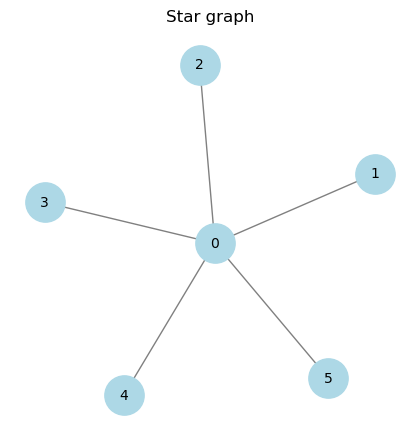

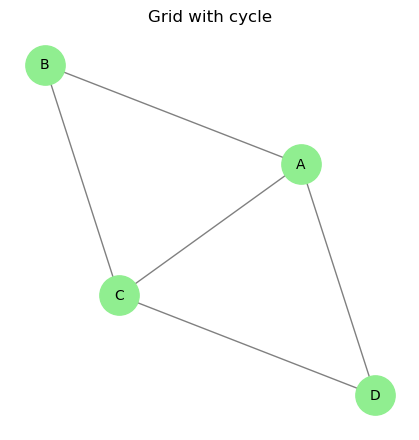

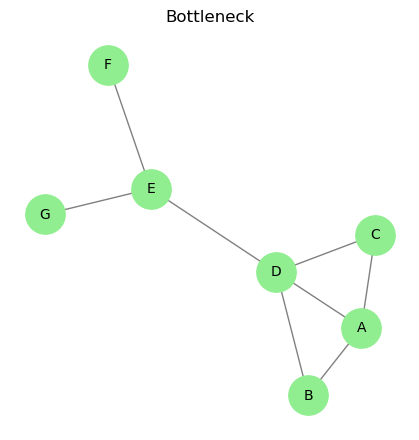


Graphe 1
Methode 1 (Naive): [((0, 1), 5.0), ((0, 2), 5.0), ((0, 3), 5.0), ((0, 4), 5.0), ((0, 5), 5.0)]
Methode 2 (Brandes): [((0, 1), 5.0), ((0, 2), 5.0), ((0, 3), 5.0), ((0, 4), 5.0), ((0, 5), 5.0)]

Graphe 2
Methode 1 (Naive): [(('A', 'B'), 1.5), (('A', 'D'), 1.5), (('A', 'C'), 1.0), (('B', 'C'), 1.5), (('C', 'D'), 1.5)]
Methode 2 (Brandes): [(('A', 'B'), 1.5), (('A', 'D'), 1.5), (('A', 'C'), 1.0), (('B', 'C'), 1.5), (('C', 'D'), 1.5)]

Graphe 3
Methode 1 (Naive): [(('A', 'B'), 1.5), (('A', 'C'), 1.5), (('A', 'D'), 4.0), (('B', 'D'), 4.5), (('C', 'D'), 4.5), (('D', 'E'), 12.0), (('E', 'F'), 6.0), (('E', 'G'), 6.0)]
Methode 2 (Brandes): [(('A', 'B'), 1.5), (('A', 'C'), 1.5), (('A', 'D'), 4.0), (('B', 'D'), 4.5), (('C', 'D'), 4.5), (('D', 'E'), 12.0), (('E', 'F'), 6.0), (('E', 'G'), 6.0)]


In [4]:
#Graph with a star
G1 = nx.star_graph(5)
plt.figure(figsize=(4, 4))
nx.draw(G1, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, font_size=10)
plt.title("Star graph")
plt.show()

#Graph with a cycle
G2 = nx.Graph()
G2.add_edges_from([("A", "B"), ("B", "C"),("C", "D"), ("D", "A"),("A", "C")])
plt.figure(figsize=(4, 4))
disposition = nx.spring_layout(G2)
nx.draw(G2, disposition, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=800, font_size=10)
plt.title("Grid with cycle")
plt.show()

#Graph with a bottelneck
G3 = nx.Graph()
edges = [("A", "B"), ("A", "C"), ("B", "D"), ("C", "D"),("D", "E"),("E", "F"), ("E", "G"),("A", "D")]
G3.add_edges_from(edges)
plt.figure(figsize=(4, 4))
disposition = nx.spring_layout(G3)
nx.draw(G3, disposition, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=800, font_size=10)
plt.title("Bottleneck")
plt.show()


graphs = [G1, G2, G3]
for i, graph in enumerate(graphs):
    print(f"\nGraphe {i + 1}")

    #Method 1
    betweenness_1 = naive_algorithm_edge_betweenness(graph)
    print("Methode 1 (Naive):", list(betweenness_1.items())[:8])
    
    #Method 2
    betweenness_2 = edge_betweeness_Brandes_method(graph)
    print("Methode 2 (Brandes):", list(betweenness_2.items())[:8])
    

We noticed that the results from our Brandes method are the same as the ones from our naive method on these graphs. We also tested it against the one from the networkx librairy and we have the same results ont these graphs.

## Functions to plot the clusters

In [5]:
def visualize_clusters(graph, clusters, title="Matplotlib-visualisation"):
    disposition = nx.spring_layout(graph, seed=10)  #We want to generate a disposition of the nodes that is always the same
    
    colors = plt.cm.get_cmap("hsv", len(clusters))  #We choose a color map to color the clusters
    
    plt.figure(figsize=(10, 7))

    #Draw the nodes, colored the same for each cluster
    for i, cluster in enumerate(clusters):
        nx.draw_networkx_nodes(graph, disposition,nodelist=list(cluster),node_size=300,node_color=[colors(i)],label=f"Cluster {i + 1}")
    
    #Draw the edges
    nx.draw_networkx_edges(graph, disposition, alpha=0.5)
    
    plt.legend()
    plt.title(title)
    plt.show()


def visualize_clusters_plotly(graph, clusters, title="Plotly-visualisation"):
    #We use plotly now to get interactive graphs 
    disposition = nx.spring_layout(graph, seed=10)  # We want to generate a disposition of the nodes that is always the same
    edge_x = []
    edge_y = []

    #Draw the edges
    for edge in graph.edges():
        x0, y0 = disposition[edge[0]]
        x1, y1 = disposition[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(x=edge_x, y=edge_y,line=dict(width=0.5, color="#888"),hoverinfo="none",mode="lines")

    #Draw nodes
    node_traces = []
    colors = plt.cm.get_cmap("hsv", len(clusters))
    #colors = plt.cm.get_cmap("tab20", len(clusters)) we change the color map because the new one is better
    
    #Draw the nodes, colored the same for each cluster
    for i, cluster in enumerate(clusters):
        node_x = []
        node_y = []
        for node in cluster:
            x, y = disposition[node]
            node_x.append(x)
            node_y.append(y)
        
        node_trace = go.Scatter(x=node_x, y=node_y,mode="markers",
            marker=dict(size=10,color=f"rgba({int(colors(i)[0]*255)}, {int(colors(i)[1]*255)}, {int(colors(i)[2]*255)}, 0.8)",line_width=2),
            name=f"Cluster {i + 1}")
        node_traces.append(node_trace)
    
    #Create figure
    fig = go.Figure(data=[edge_trace] + node_traces,layout=go.Layout(title=title,titlefont_size=16,showlegend=True,hovermode="closest",margin=dict(b=0, l=0, r=0, t=40),xaxis=dict(showgrid=False, zeroline=False),
                                                                     yaxis=dict(showgrid=False, zeroline=False)))
    fig.show(renderer="browser")



def global_modularity(clusters, G):
    m = G.number_of_edges()  #Total number of edges
    
    #Modularity initialized to 0
    Q = 0

    #Iterate over each cluster
    for cluster in clusters:

        cluster_nodes = list(cluster) #convert the set to a list

        #Subgraph containing only the nodes and edges of the cluster
        subgraph = G.subgraph(cluster_nodes)

        #Number of edges inside the cluster
        L_c = subgraph.number_of_edges()

        #Sum of the degrees of the nodes in the cluster (all the edges that are connected to the nodes in the cluster)
        k_c = sum(G.degree(n) for n in cluster_nodes)

        #Add the modularity for the cluster
        Q += (L_c / m) - (k_c / (2*m))**2

    #Return the global modularity
    return Q


def create_and_generate_wordclouds_from_graph(graph, clusters):
    # The objective is from the graph and the culsters of the nodes to generate word clouds for each cluster

    #Step 1 : Create the dictionary of clusters
    dictionary_clusters = {}
    for i, cluster in enumerate(clusters):
        cluster_list = [graph.nodes[node]["name"] for node in cluster if "name" in graph.nodes[node]]
        dictionary_clusters[i] = cluster_list
    
    #Step 2: Generate Word Clouds for each cluster
    for cluster_id, cluster_phrases in dictionary_clusters.items():
        
        # Combine all phrases from the cluster
        text = ' '.join(cluster_phrases).lower() #We concatenate all the names of the nodes in the cluster
        text = ' '.join(set(text.split()))  #Remove duplicates
        text = re.sub(r'[^\w\s]', '', text)  #Remove non-alphanumeric characters
        text = text.lower()

        print(f"Cluster {cluster_id + 1}: {text[:100]}...")  # Preview the first 100 characters

        # Generate the Word Cloud
        wordcloud = WordCloud(max_words=5, background_color="white").generate(text)

        # Display the Word Cloud
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear") #we add bilinear, it's more beautiful
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {cluster_id + 1}")
        plt.show()

    return dictionary_clusters

# Test on subgraph of the Wikipedia dataset

Here we first load the dataset and then we take a subset from it before running our experiments

## Functions to load the graph

In [6]:
#for sptrip, split, etc. see above
def load_edges(file_path):
    #Load edges from the file to give them to networkx
    edges = []
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            source, target = map(int, line.strip().split())
            edges.append((source, target))
    return edges


def load_page_names(file_path):
    #Load the names of the pages from the file
    page_names = {}
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            line = line.strip()
            parts = line.split(' ', 1)
            if len(parts) == 2:  #Sanity check : the line contains two parts (id and name)
                page_id, page_name = parts
                page_names[int(page_id)] = page_name
    return page_names


## Load and check properties of the big graph

In [7]:
#Path to files
base_path = "data/big_graph"
edges_file = f"{base_path}/wiki-topcats.txt.gz"
page_names_file = f"{base_path}/wiki-topcats-page-names.txt.gz"

#Load data
edges = load_edges(edges_file)
page_names = load_page_names(page_names_file)

#Create the graph
G = nx.Graph()
G.add_edges_from(edges)

#Add names of each node
nx.set_node_attributes(G, page_names, "name")

#Print info
print(f"Number of nodes : {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes : 1791489
Number of edges: 25447873


In [8]:
#Check if the graph has cycles
try:
    cycle = nx.find_cycle(G)
    print(f"Graph contains at least one cycle : {cycle}")
except nx.NetworkXNoCycle:
    print("No cycles")

#Is it a DAG?
if nx.is_directed_acyclic_graph(G):
    print("It's a DAG")
else:
    print("It's not a DAG")


#Find the number of connected components
connected_components = list(nx.connected_components(G))
print(f"how many connected components ? : {len(connected_components)}")
component_sizes = [len(component) for component in connected_components]
print(f"how many nodes per component? : {component_sizes}")

Graph contains at least one cycle : [(2704, 2517), (2517, 8752), (8752, 2718), (2718, 2714), (2714, 2704)]
It's not a DAG
how many connected components ? : 1
how many nodes per component? : [1791489]


## Make the subgraph

Number of nodes : 1000
Number of edges : 4628


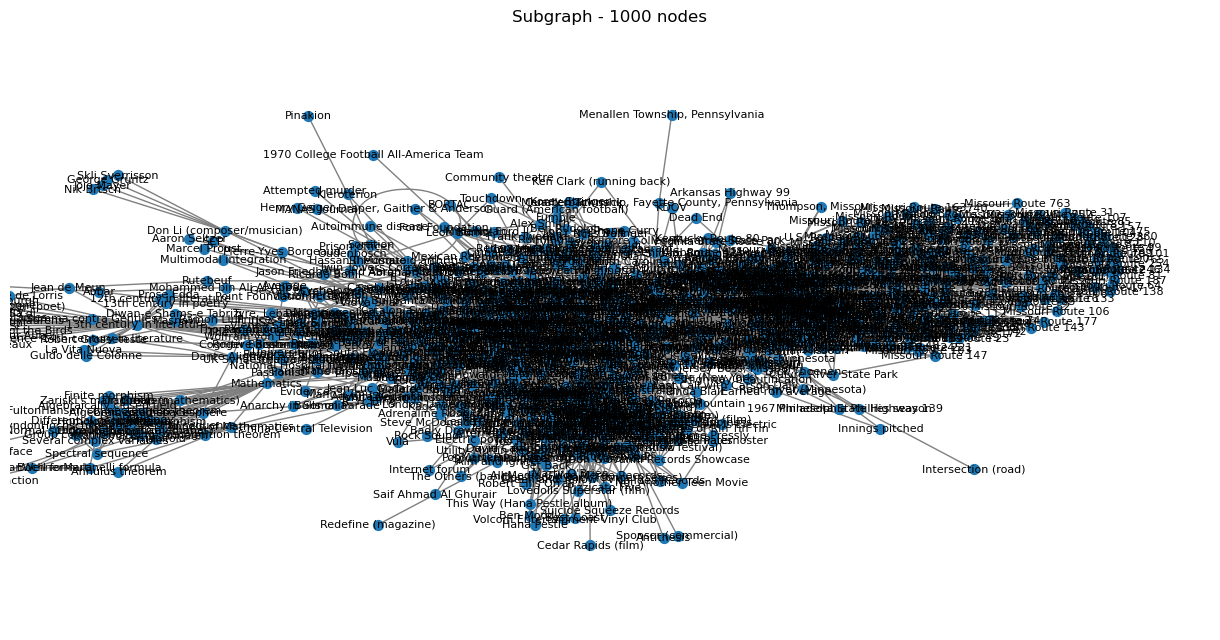

In [9]:
#Make the subgraph with first 1000 nodes
subgraph = G.subgraph(list(G.nodes)[:1000])
disposition = nx.spring_layout(subgraph, seed=10)  #To visualize the same graph each time

#Print info
print(f"Number of nodes : {subgraph.number_of_nodes()}")
print(f"Number of edges : {subgraph.number_of_edges()}")


plt.figure(figsize=(12, 6))
nx.draw(subgraph,disposition,with_labels=True,labels={node: G.nodes[node]["name"] for node in subgraph.nodes},node_size=50,font_size=8,edge_color="gray")

#Zoom
plt.xlim(-0.4, 0.4)
plt.ylim(-0.4, 0.4)

plt.title("Subgraph - 1000 nodes")
plt.show()

In [10]:
#Check if the graph has cycles
try:
    cycle = nx.find_cycle(subgraph)
    print(f"Graph contains at least one cycle : {cycle}")
except nx.NetworkXNoCycle:
    print("No cycles")

#Is it a DAG?
if nx.is_directed_acyclic_graph(subgraph):
    print("It's a DAG")
else:
    print("It's not a DAG")


#Find the number of connected components
connected_components = list(nx.connected_components(subgraph))
print(f"how many connected components ? : {len(connected_components)}")
component_sizes = [len(component) for component in connected_components]
print(f"how many nodes per component? : {component_sizes}")

Graph contains at least one cycle : [(64, 2288), (2288, 66769), (66769, 64)]
It's not a DAG
how many connected components ? : 2
how many nodes per component? : [2, 998]


## Test of clustering algorithm based on betweenness (Brandes method)

We first apply our previous defined function with some parameters (we don't put here all the implementations we did, just the last one for clarity)

In [11]:
number_edges_to_remove_per_iteration = 10
total_number_edges_to_remove = 1250
k_sources=None
graph_with_edges_removed,clusters,betwenness, liste_number_clusters, liste_partial_clusters = remove_edges_with_highest_betweenness_Brandes(subgraph,number_edges_to_remove_per_iteration=number_edges_to_remove_per_iteration, total_number_edges_to_remove=total_number_edges_to_remove, k_sources=k_sources)


Removal of edges: 100%|██████████| 125/125 [09:36<00:00,  4.61s/it]


C:\Users\antoi\AppData\Local\Temp\ipykernel_28572\384568737.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("hsv", len(clusters))


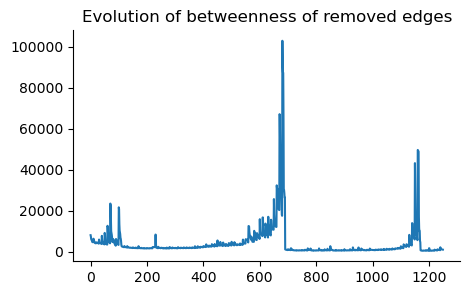

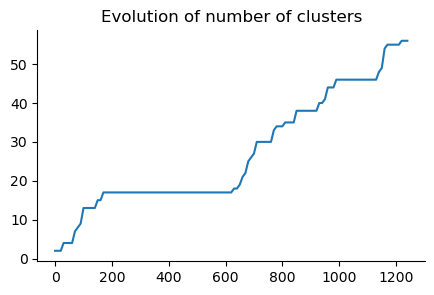

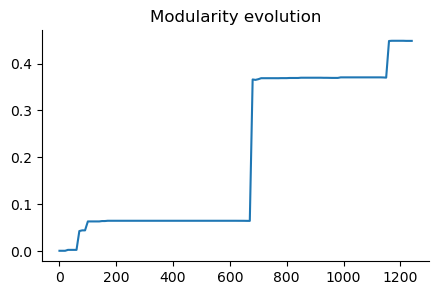

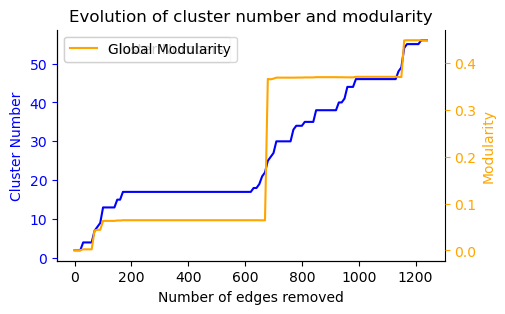

In [12]:
#See the clusters
visualize_clusters_plotly(subgraph, clusters)

#PLot the evolution or the betweenness of removed edges
plt.figure(figsize=(5, 3))
plt.title("Evolution of betweenness of removed edges")
plt.plot(betwenness)
sns.despine()

#PLot the evolution of the number of clusters
plt.figure(figsize=(5, 3))
plt.title("Evolution of number of clusters")
plt.plot(range(0,total_number_edges_to_remove,number_edges_to_remove_per_iteration),liste_number_clusters)
sns.despine()

#PLot the evolution of the modularity
plt.figure(figsize=(5, 3))
plt.title("Modularity evolution")
plt.plot(range(0,total_number_edges_to_remove,number_edges_to_remove_per_iteration),list(global_modularity(partial_clusters, subgraph) for partial_clusters in liste_partial_clusters))
sns.despine()



#Plot the evolution of the number of clusters and the modularity on the same graph
plt.figure(figsize=(5, 3))
plt.title("Evolution of cluster number and modularity")

#use seaborn for the first line: evolution of the number of clusters
sns.lineplot(x=range(0, total_number_edges_to_remove, number_edges_to_remove_per_iteration),y=liste_number_clusters,label="Cluster Numbers",color="blue")

#Creation of a 2nd axe for modularity
ax1=plt.gca()
ax2=ax1.twinx()

#use seaborn for the second line: evolution of the modularity
sns.lineplot(x=range(0, total_number_edges_to_remove, number_edges_to_remove_per_iteration),y=[global_modularity(partial_clusters, subgraph) for partial_clusters in liste_partial_clusters],
             label="Global Modularity",color="orange",ax=ax2)

#Legend
ax1.set_xlabel("Number of edges removed")
ax1.set_ylabel("Cluster Number", color="blue")
ax2.set_ylabel("Modularity", color="orange")

#Colors
ax1.tick_params(axis='y', colors="blue")
ax2.tick_params(axis='y', colors="orange")

sns.despine(ax=ax1, right=False)
sns.despine(ax=ax2, left=False)
plt.show()


Cluster 1: chiasm optic syndrome chiasmal...


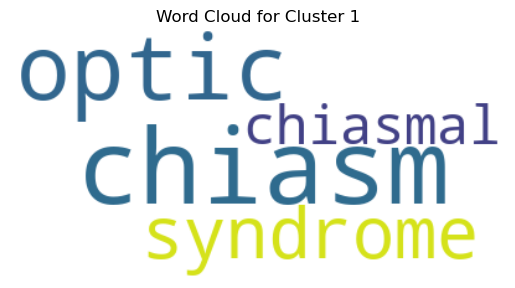

Cluster 2: pinakion kleroterion...


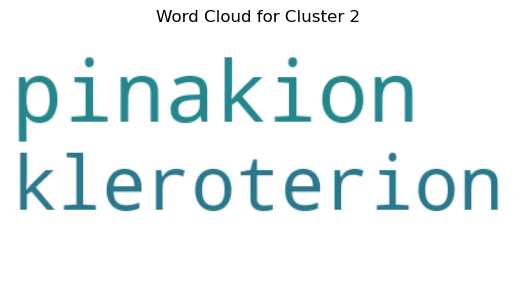

Cluster 3: bergmanweil ruled cayleys mathematics bochnermartinelli geometry 3manifold of field connected bing c...


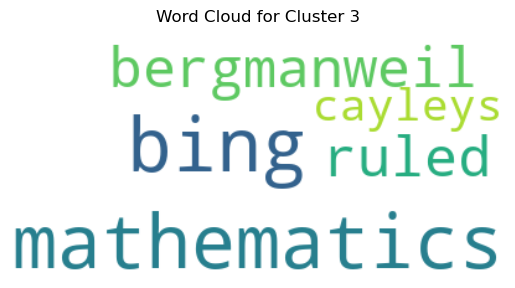

Cluster 4: township county fayette pennsylvania menallen...


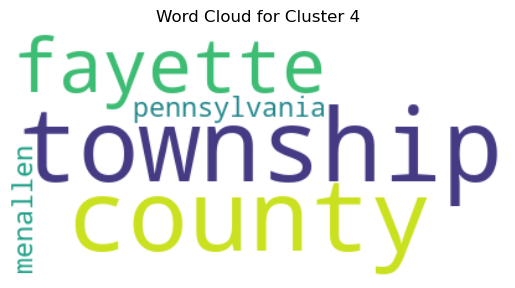

Cluster 5: of 364 randolph troy 571 124 caruthersville information hannibal 76 118 371 142 92 25 79 keokuk 13 1...


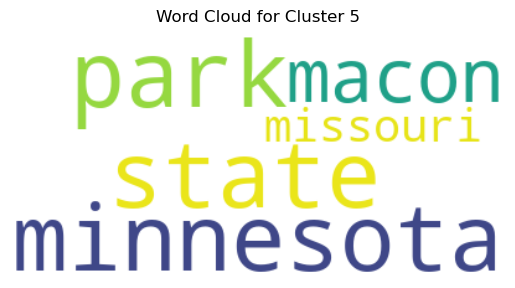

Cluster 6: lower school parker...


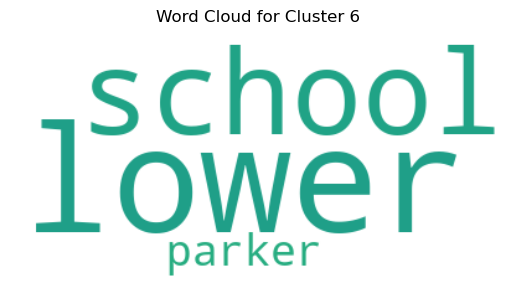

Cluster 7: lecoma missouri...


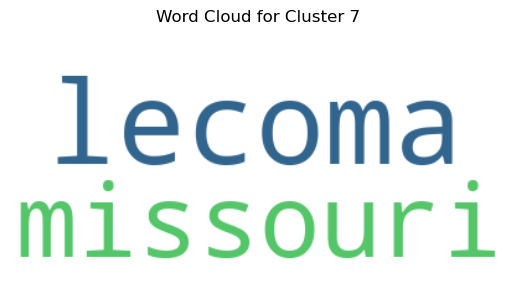

Cluster 8: of kagenna neurosurgery s folk alghurair happiness chronicle anderson unesco roosevelt corporation s...


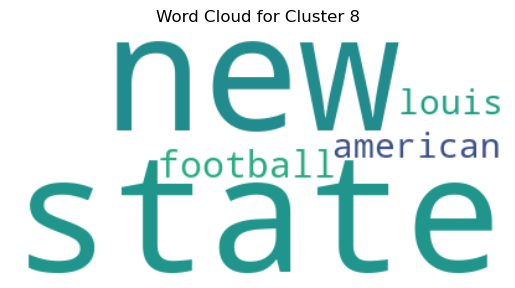

Cluster 9: kentucky end dead route state virginia 80 missouri...


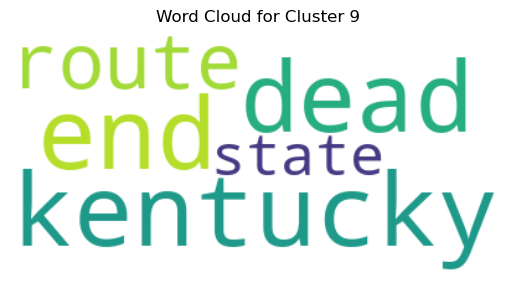

Cluster 10: madrid county 162 153 route new missouri...


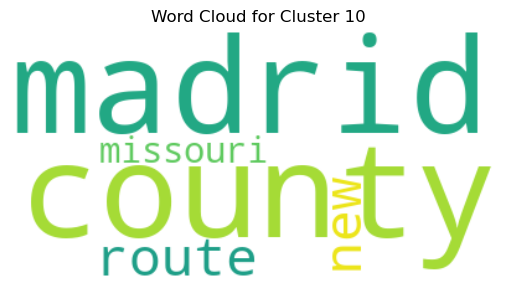

Cluster 11: mohammed al bin lebanon samir ali abbar tyre...


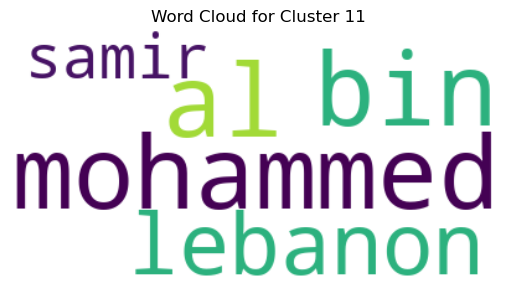

Cluster 12: of south florida university herd thunder...


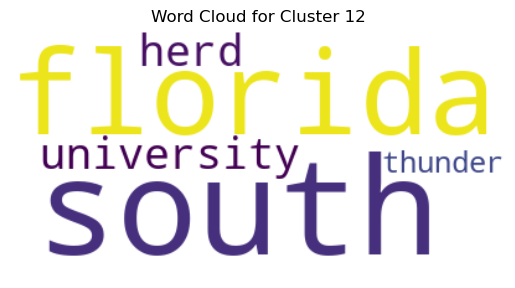

Cluster 13: sponsor antithesis commercial basement show...


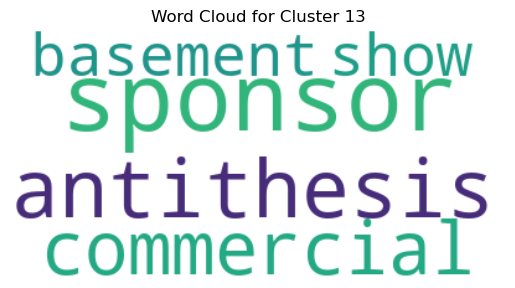

Cluster 14: science lovedolls of all boy lowe rapids orrall babes happiness hole shane popmatters dischord light...


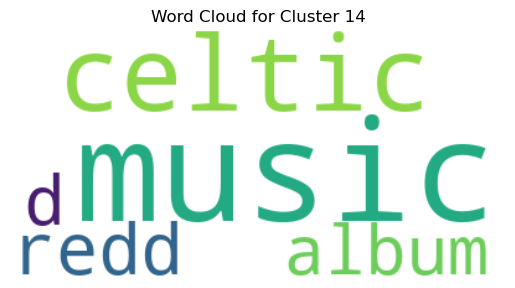

Cluster 15: average season run pitched thoenen earned dick philadelphia phillies innings 1967...


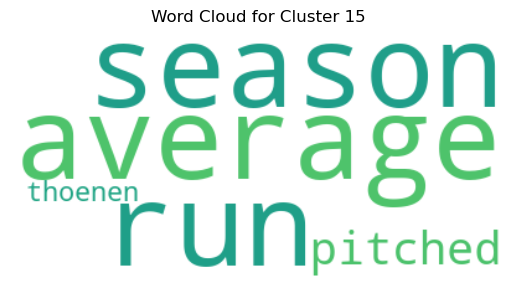

Cluster 16: gervase of gulistan von rutebeuf heinrich mayence nibelungenlied vogler stade 12th la diwane mathieu...


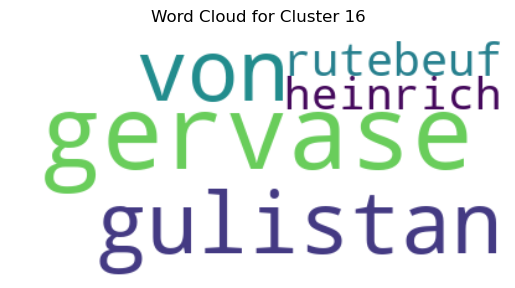

Cluster 17: henry geiger manas journal...


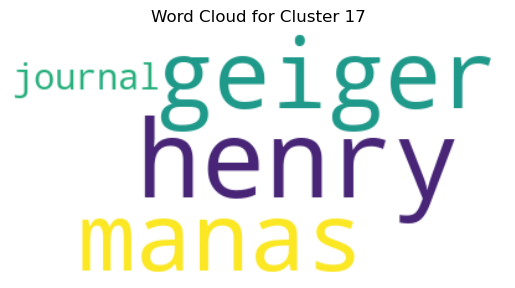

Cluster 18: mayer brtsch george skli jojo don gruntz li nik sverrisson composermusician...


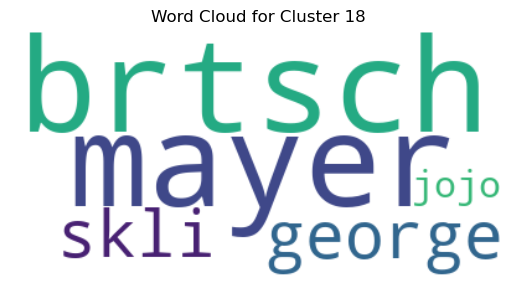

Cluster 19: seltzer and aaron jason friedberg...


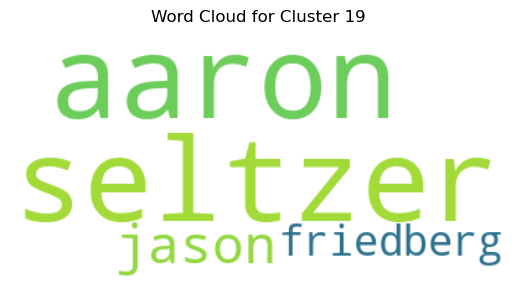

Cluster 20: alabama running back ken evergreen clark...


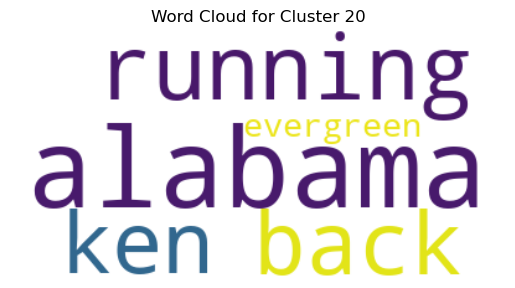

Cluster 21: ben rudolph...


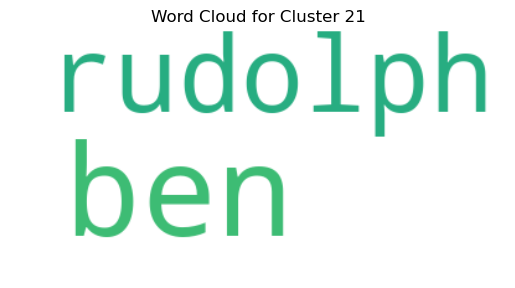

Cluster 22: team burns leon college 1970 allamerica football...


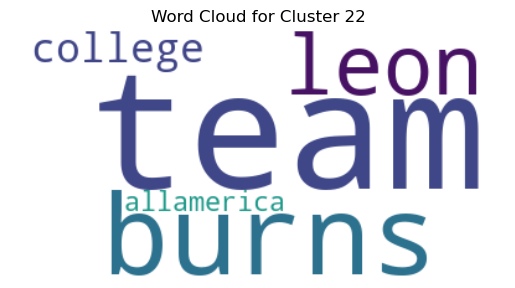

Cluster 23: and sound aquarian weekly ignite aim magazine rock redefine the...


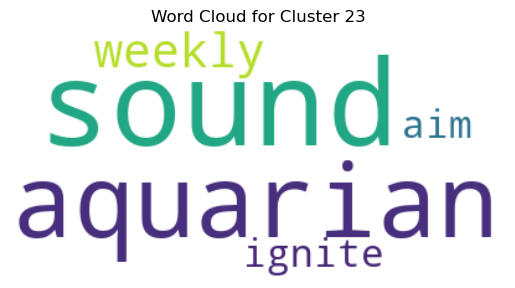

Cluster 24: roger bacon...


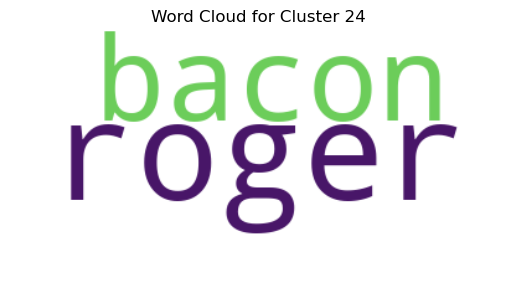

Cluster 25: von wolfram eschenbach...


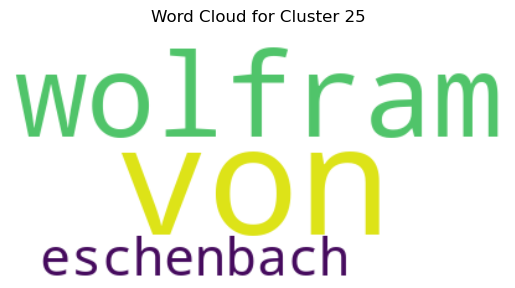

Cluster 26: sic goner mountain records ty segall alps arabia...


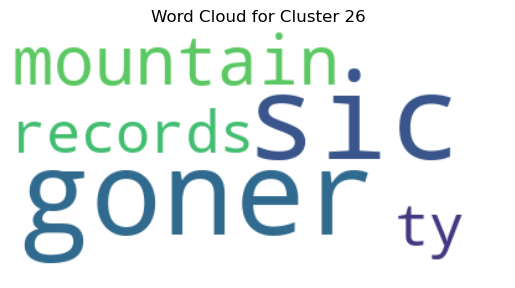

Cluster 27: carolina julian north...


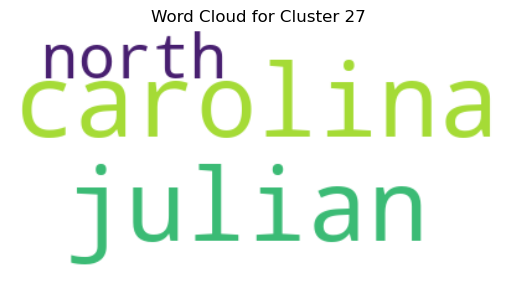

Cluster 28: beautification highway...


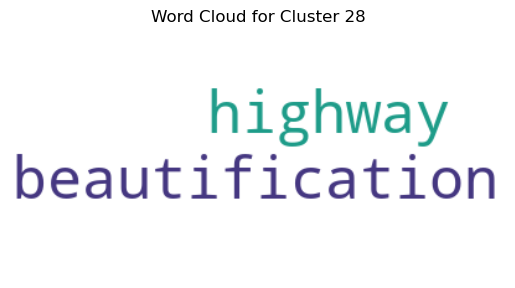

Cluster 29: marty hana hana pestle way moody album ben obrien this...


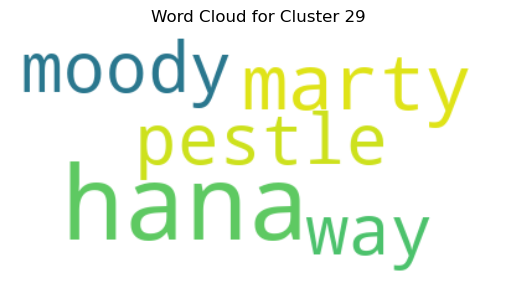

Cluster 30: space of hearts records...


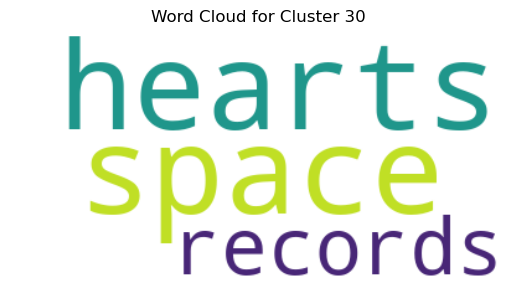

Cluster 31: compact cassette...


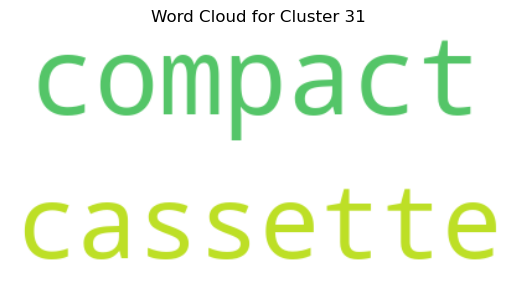

Cluster 32: village studio the...


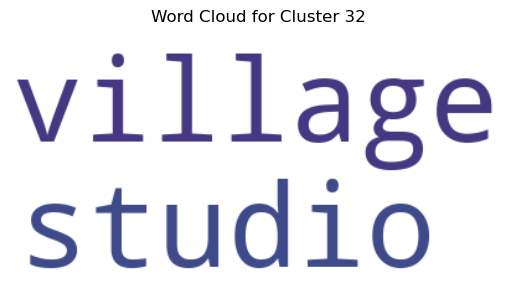

Cluster 33: al kilgore herrion thomas alex college mike nolan lucas smith...


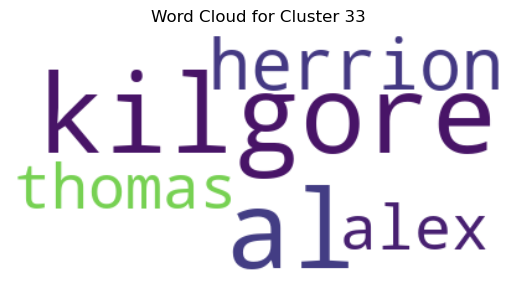

Cluster 34: robert grosseteste...


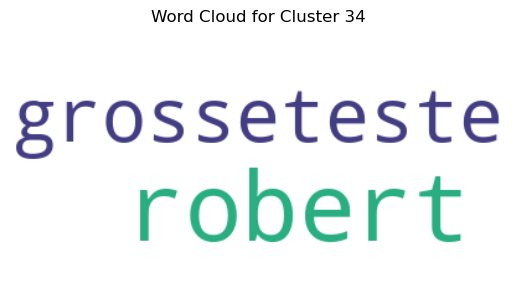

Cluster 35: sortition...


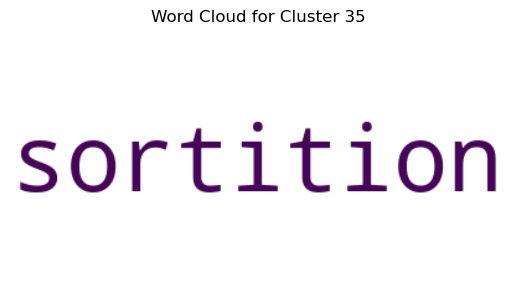

Cluster 36: chautauqua kansas county...


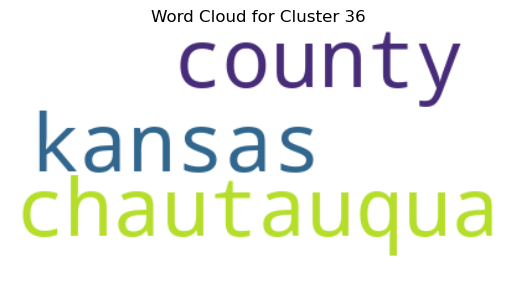

Cluster 37: devil electric is geekfest the...


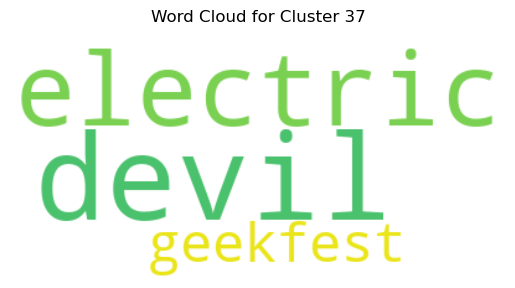

Cluster 38: oudenbosch...


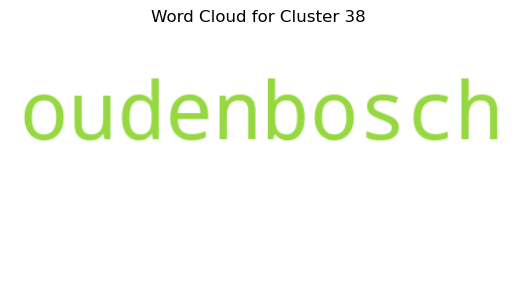

Cluster 39: abraham maslow...


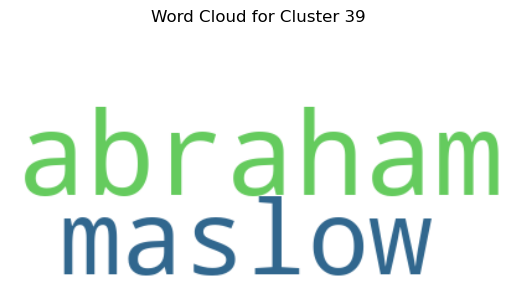

Cluster 40: fumble touchdown korey stringer...


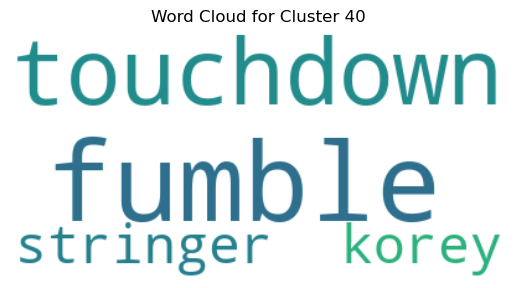

Cluster 41: missouri potosi...


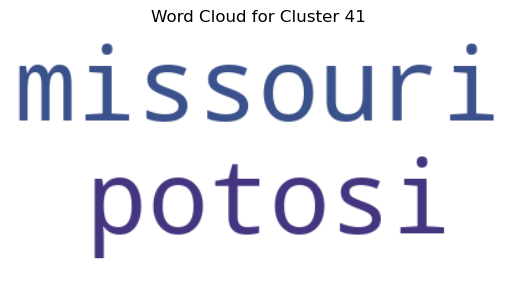

Cluster 42: 2007 running back nfl draft...


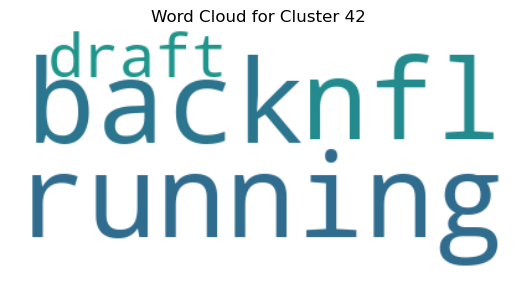

Cluster 43: borgeaud pierreyves...


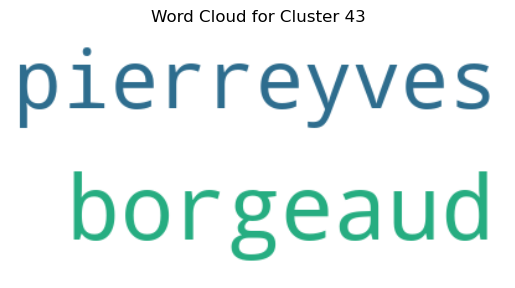

Cluster 44: quarterback sack...


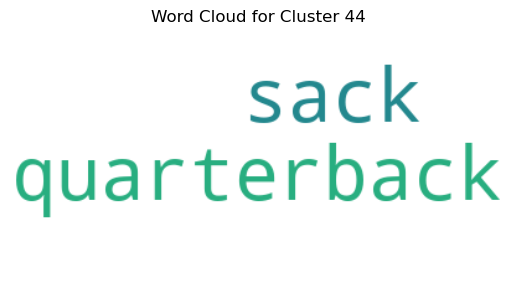

Cluster 45: room studio recording control...


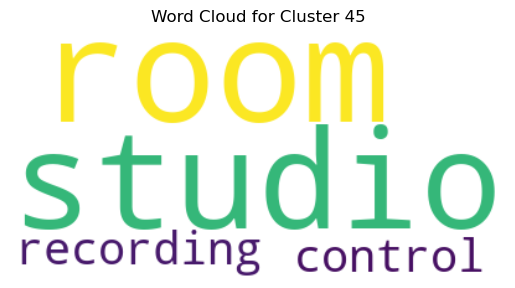

Cluster 46: yard...


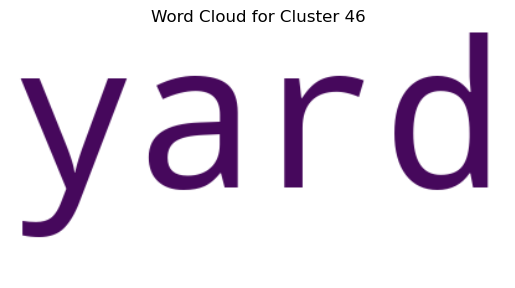

Cluster 47: 421 us route...


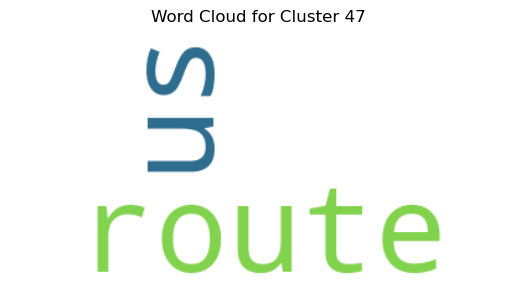

Cluster 48: bully wooly...


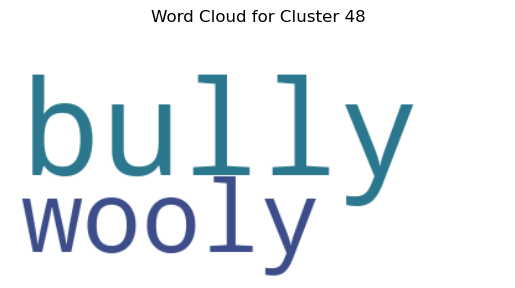

Cluster 49: on bulls parade...


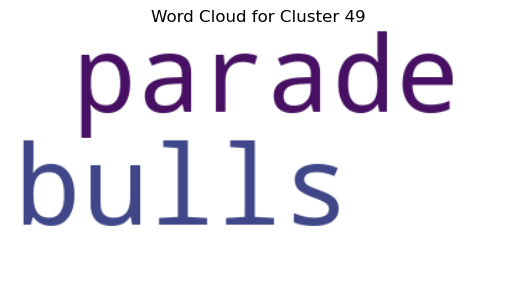

Cluster 50: average...


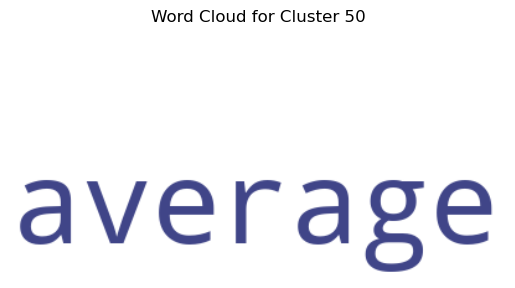

Cluster 51: out selling...


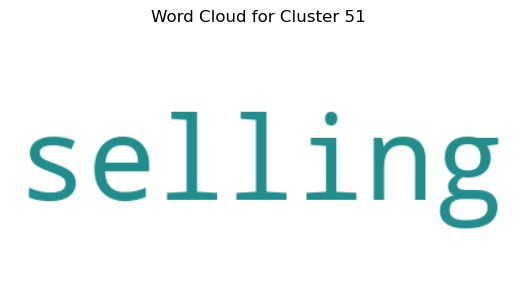

Cluster 52: utah of university...


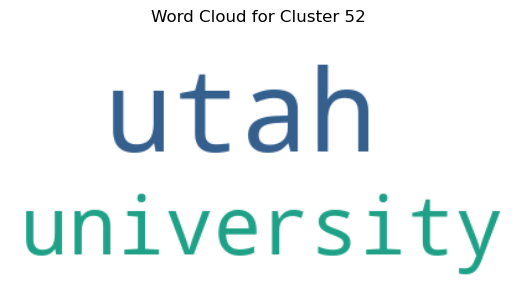

Cluster 53: sunn...


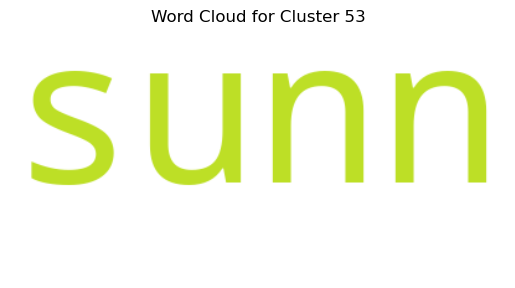

Cluster 54: the rage against machine...


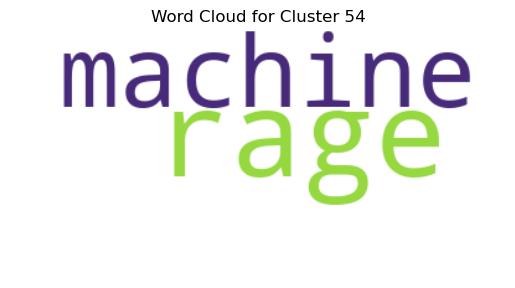

Cluster 55: david campbell composer...


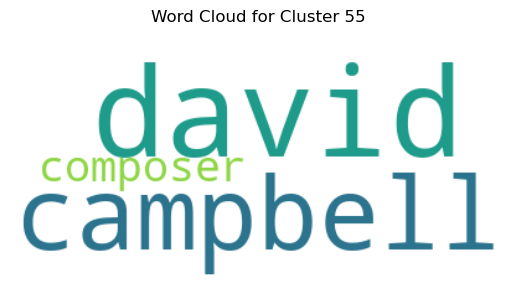

Cluster 56: summa gentiles contra...


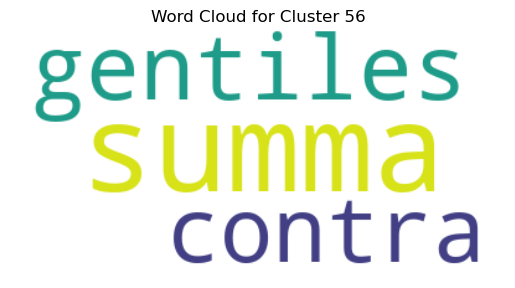

In [13]:
dictionary_clusters = create_and_generate_wordclouds_from_graph(subgraph, clusters)